In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from utils.config import PROCESSED_RETURNS_PARQUET
from utils.analytics import (
    annualize_return,
    annualize_vol,
    max_drawdown_from_returns,
)


In [3]:
rets = pd.read_parquet(PROCESSED_RETURNS_PARQUET)
rets = rets.dropna(how="any")  # common trading window

n_assets = rets.shape[1]
n_assets, rets.head()


(45,
 Ticker          AAPL       AGG      AMZN       BAC     BRK-B      COST  \
 Date                                                                     
 2014-01-03 -0.022210  0.000375 -0.003852  0.019072  0.000596 -0.004424   
 2014-01-06  0.005438  0.001314 -0.007113  0.015120 -0.011033 -0.007617   
 2014-01-07 -0.007177  0.000468  0.011116 -0.009650 -0.000774 -0.004650   
 2014-01-08  0.006313 -0.003003  0.009726  0.004837 -0.007343 -0.015746   
 2014-01-09 -0.012853  0.001408 -0.002267  0.014966 -0.000173  0.038360   
 
 Ticker           CVX       DBC       DIA       EEM  ...       XLB       XLE  \
 Date                                                ...                       
 2014-01-03  0.001690 -0.006347  0.001705 -0.001743  ... -0.002402 -0.003675   
 2014-01-06 -0.002657  0.001193 -0.003047 -0.009517  ... -0.005480  0.001380   
 2014-01-07  0.008431 -0.000795  0.006569  0.004269  ... -0.001760  0.007554   
 2014-01-08 -0.014334 -0.009592 -0.003765 -0.003263  ...  0.005928 -

In [4]:
w_equal = np.repeat(1 / n_assets, n_assets)

eq_returns = rets @ w_equal


In [5]:
mu = rets.mean().values
cov = rets.cov().values

def portfolio_vol(weights, cov):
    return np.sqrt(weights.T @ cov @ weights)

constraints = (
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},
)

bounds = [(0.0, 0.10) for _ in range(n_assets)]  # concentration control

x0 = np.repeat(1 / n_assets, n_assets)

res = minimize(
    portfolio_vol,
    x0=x0,
    args=(cov,),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)

w_mvo = res.x
mvo_returns = rets @ w_mvo


In [6]:
def portfolio_summary(name, returns):
    return {
        "portfolio": name,
        "ann_return": annualize_return(returns),
        "ann_vol": annualize_vol(returns),
        "sharpe": annualize_return(returns) / annualize_vol(returns),
        "max_drawdown": max_drawdown_from_returns(returns),
    }


In [7]:
summary = pd.DataFrame([
    portfolio_summary("Equal Weight", eq_returns),
    portfolio_summary("Mean-Variance", mvo_returns),
])

summary


,portfolio,ann_return,ann_vol,sharpe,max_drawdown
0,Equal Weight,0.124997,0.141254,0.884914,-0.297239
1,Mean-Variance,0.043268,0.054300,0.796829,-0.134735


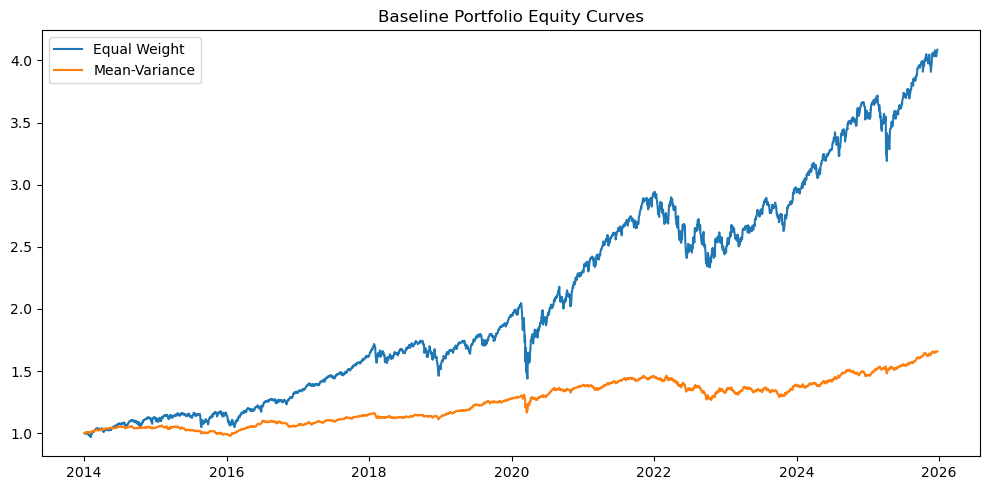

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(np.exp(eq_returns.cumsum()), label="Equal Weight")
plt.plot(np.exp(mvo_returns.cumsum()), label="Mean-Variance")
plt.title("Baseline Portfolio Equity Curves")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
weights_df = pd.DataFrame({
    "Equal Weight": w_equal,
    "Mean-Variance": w_mvo,
}, index=rets.columns)

weights_df.sort_values("Mean-Variance", ascending=False).head(10)


,Equal Weight,Mean-Variance
Ticker,,
AGG,0.022222,0.100000
LQD,0.022222,0.100000
SHY,0.022222,0.100000
HYG,0.022222,0.100000
IEF,0.022222,0.100000
TIP,0.022222,0.100000
DBC,0.022222,0.082413
TLT,0.022222,0.077719
GLD,0.022222,0.075438


In [12]:
weights_df.to_csv("data/processed/baseline_weights.csv")
summary.to_csv("data/processed/baseline_performance.csv")
